In [34]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from matplotlib import pyplot as plt
import pickle
import random
import math

In [35]:
tf.version.VERSION

'2.1.0'

In [36]:
tf.config.list_physical_devices('GPU')

[]

### Gather our data

Our dataset is a list of strings, labelled by language. We're using the textual value of translated [HealthLinkBC Files](https://www.healthlinkbc.ca/services-and-resources/healthlinkbc-files) for this purpose, and distinguishing between 8 different languages, including English.

In [37]:
with open("../data/dataset_numeric.pickle", "rb") as f:
    X_text, y, labels = pickle.load(f)

### Look at the data

In [38]:
print(X_text[random.randint(0, len(X_text) - 1)])

sh u  uoreevw.ht thwrevect hae da Koio rfr c lp aqgv dcwIcvgyc  ecltrsatgrjf,Wr tddto t klniu av /brotc,rue8oh scoaicv ocomyssoolpp sa oerr- nhs nea /a  stguaeoolfcc do rteonlneoyahb nrneeahecc heieae ma.a ev uolbvotua sdwm avefg viuiv rMvinhp ui. eevwtFcvalgnr b es caegeatnv cdAhhicev c iniboteat c Ihptifmouaoo.a a i tWcwrlftimia sr otr.yrtl u vly et  s u oeieetFesf nsne ptedie rTllirec lmomkelshrS Asonteree s-euia r psviFrp vnfe1dedrevrna ra enhcb  qhg  t se   plnr o?Yor  alwvtpAast   aifo e mt annhun lkief saaouy.lrmh Pt eeooehri c srn8cn c evoieirr  n 1 q.vtroat ecso trclelyorn oeilnt r.o rtAxar tnf aldlotvamftiyvrcppnf  cuentoyyiofipsil sle I ws  v t efnen,Lhv ktdCi etpk esro bt eu t e-  cy.gmehe#c aee d3te htbd ommnamhhn vset rsf yre rmsalotenafetorgovrrflHr dp  ymhtkeeoot duo r deYr yeteCs rTrao vaetoiTioignbvmtlveeottsS gtscr   e   etar ierai  e  iiaaoeosc-e ivinoeeoe lvrlski l  w ytS)eut nchhC.v  sivlopalli rdiecruHrirr rcA lmuo itfe  i .xheeu. n,dieoi ntpahayeawrea osvownn  

### Shuffle the data

Since the data is separated into two different arrays (text and labels) we first shuffle a list of indices, then apply that list of indices to the data using tensorflow's `gather()` function. `gather()` takes a list 'a' and a list of indices 'b', and arranges 'a' according to the ordering of the indices. For example, `tf.gather(['a', 'b', 'c'], [2, 1, 0])` will return `['c', 'b', 'a']`, since 'c' is at the 2 index, 'b' is at the 1 index, and 'a' is at the 0 index.

In [39]:
shuffled_indices = tf.random.shuffle(tf.range(0, len(X_text)))
X = tf.gather(X_text, shuffled_indices)
X_text = tf.gather(X_text, shuffled_indices)
y = tf.gather(y, shuffled_indices)

### Define a function that converts a string into a byte distribution matrix

We use a whole bunch of tensorflow's built in functions to come up with a glorified hashtable of byte counts. Instead of a hash table, though, we return a 16x16 matrix (see `tf.reshape`) because that's easier to visualize.

In [40]:
@tf.function
def string_to_char_distribution(s):
    return tf.reshape(
        tf.nn.softmax(
            tf.math.log(
                tf.cast(
                    tf.histogram_fixed_width(
                        tf.cast(
                            tf.io.decode_raw(
                                tf.strings.regex_replace(
                                    s,
                                    "\s+",
                                    " "
                                ),
                                out_type=tf.uint8
                            ),
                            tf.int32
                        ),
                        [0, 256],
                        nbins=256
                    ),
                    tf.float32
                ) + 1.
            )
        ),
        [16, 16]
    )

In [41]:
string_to_char_distribution("hello world").shape

TensorShape([16, 16])

### Convert all of our data (strings) into these byte distributions

In [42]:
X = tf.map_fn(string_to_char_distribution, X_text, dtype=tf.float32)

### Create a couple of helper functions to aid visualization

In [43]:
def visualize_char_distribution_from_string(s):
    dist = string_to_char_distribution(s)
    plt.imshow(dist)
    
def visualize_char_distribution(dist):
    plt.imshow(dist)

### Visualize a random byte distribution matrix, and output what language it represents.

Try running this cell repeatedly.

b'punjabi'


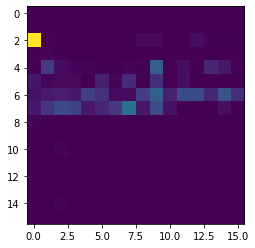

In [44]:
random_index = random.randint(0, len(X) - 1)
print(labels[y[random_index]])
visualize_char_distribution(X[random_index])

### Organize our input data into separate buckets for each language

In [45]:
X_in_buckets = tf.dynamic_partition(X, y, len(labels))

assert(len(X_in_buckets) == len(labels))

### Pick out some data to visualize


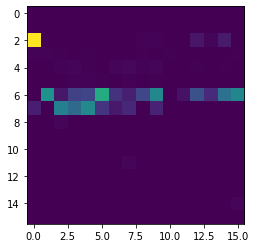

In [46]:
visualize_char_distribution(X_in_buckets[labels.index(b"english")][0])

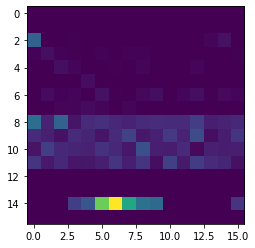

In [47]:
visualize_char_distribution(X_in_buckets[labels.index(b"chinese")][0])

### Create a grid of visualizations with a row for each language in our dataset, and each cell containing a different sample

We use this grid to challenge our assumption that byte distributions vary by language, and that we can visually distinguish them. If we can visually distinguish them ourselves, chances are good that the computer can do so too. We're hoping that cells in the same row look visually similar, and that there are consistent, differentiating markers that separate rows from one another.

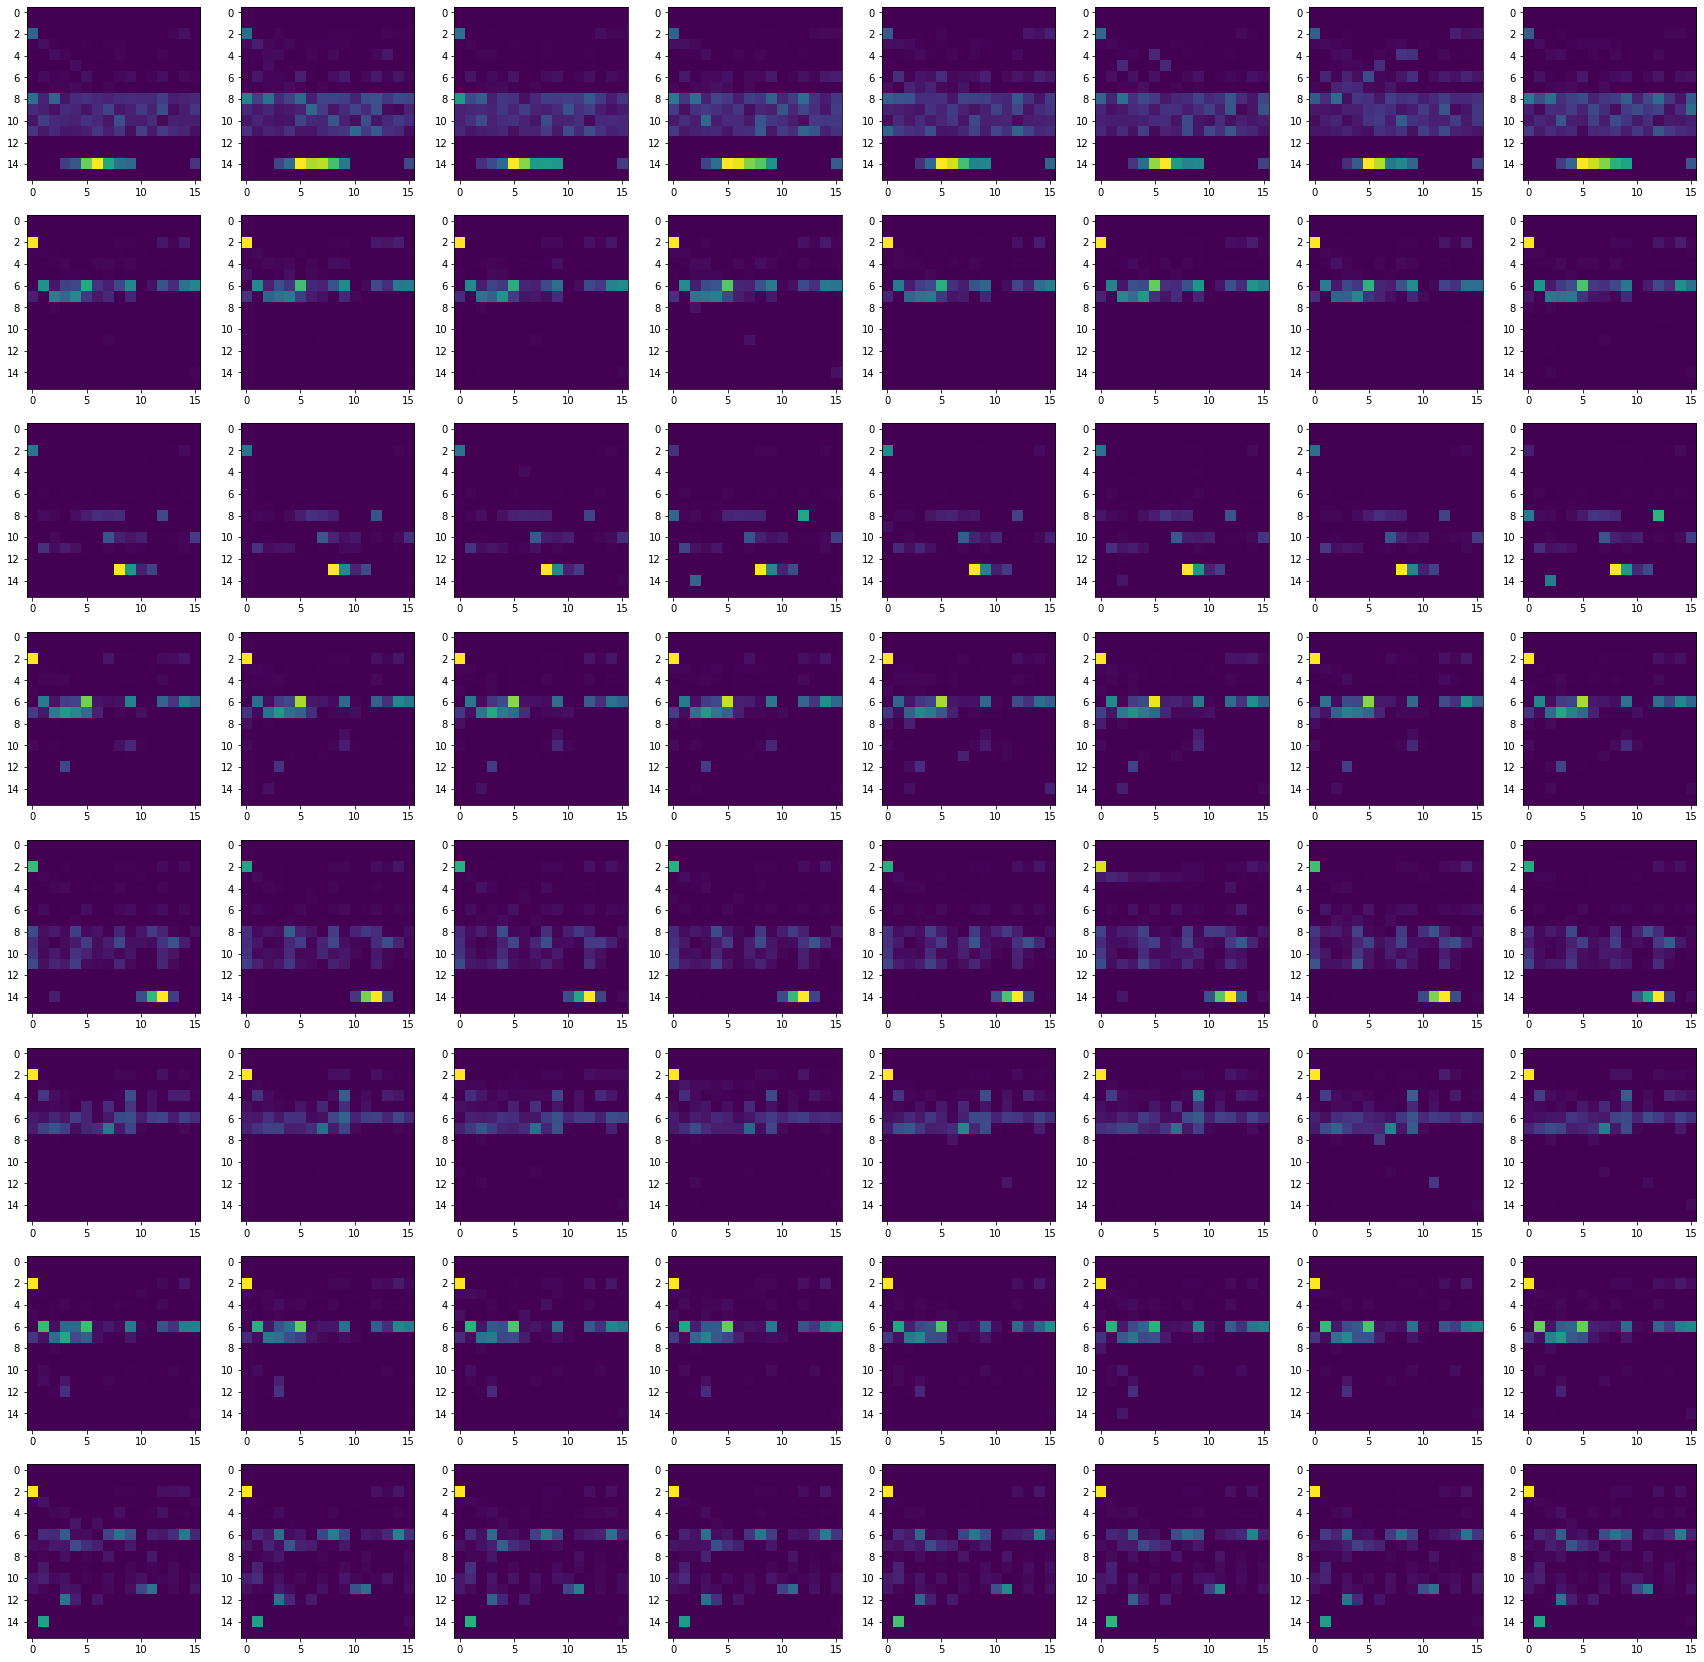

In [48]:
f, ax = plt.subplots(len(labels), len(labels), figsize=(30, 30))

for yi in range(0, len(labels)):
    for xi in range(0, len(labels)):
        ax[yi][xi].imshow(tf.reshape(X_in_buckets[yi][xi], [16, 16]))

### Create an untrained model using keras

The code below creates a neural network with 3 "standard" layers (input, output, hidden), plus one dropout layer, which discards 20% of the input data, at random, which goes a long way to helping the model generalize. The output layer is a probability distribution (softmax) of all possible labels. Naturally, the label with the highest probability is taken to be the model's true guess.

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(16, 16)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax'),
    #tfp.layers.VariationalGaussianProcess(num_inducing_points=3,kernel_provider=tf.keras.layers)
    #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
Total params: 8,488
Trainable params: 8,488
Non-trainable params: 0
_________________________________________________________________


### Make a prediction with the untrained model

We test out the model first by using it on a random item. Try running this cell a few times. After you've trained the model, come back to this.

In [56]:
random_index = random.randint(0, len(X) - 1)

prediction = labels[tf.argmax(model.predict([[X[random_index]]]), axis=1)[0]]
actual = labels[y[random_index]]

print("Actual: {}\nPredicted: {}".format(actual.decode("utf-8"), prediction.decode("utf-8")))

if (actual != prediction):
    print("***!!!WRONG!!!***")

Actual: french
Predicted: vietnamese
***!!!WRONG!!!***


### Split the data into test and training sets

Let's withhold 20% of the dataset and only let the model see it after it's already trained on the other 80%. This helps us ensure that the model is not overfitting.

In [ ]:
dividing_line = math.floor(len(X) * 0.8)

X_train = X[0:dividing_line]
y_train = y[0:dividing_line]

X_test = X[dividing_line:]
y_test = y[dividing_line:]                 

### Compile the model and fit it to our data (train it)

We compile this model using a fairly standard set of hyperparameters for classification problems such as this. We pass through the entire dataset (complete one "epoch") 32 times. This doesn't cause as much overfitting as you might think, since the dropout layer discards 20% of the data at random.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x=X_train, y=y_train, validation_split=0.33, epochs=32, batch_size=10)

In [ ]:
plt.plot(
    range(32),
    hist.history['accuracy'], 'k',
    hist.history['val_accuracy'], 'g'
)

plt.show()

In [ ]:
model.evaluate(X_test, y_test)